# Plot stats of dv/v model parameters with MCMC.

2023.4.4 Kurama Okubo

Plot MCMC stats of model paramters and AIC/BIC.

- 2023/4/19 Update for the case with fixed model parameters

## Plot list
1. All model parameter with base and and wlin model.
2. The comparison of AIC and BIC between the models.
3. Model parameter of blin; plot as a function of fault normal distance.

## Removal of FROB
Some of stations in BP network has an potentially intrumental or environmental noise at 1.0Hz and some other frequencies. `BP.FROB` shows it in all 3 components during almost half of the analyzing period (2012-2022). 

<img src="PSD_BP.FROB.40.SP1.png" alt="fig_FROB" width="400"/>
Figure. Example of 1 day PSD at BP.FROB vertical component.

It has an effect more on the auto-correlation as the periodic noise causes strong coherence to the other frequency components. It is mitigated with the cross-correlation as the periodic noise is not always coherent to the stations without it. The channel weighted dv/v also decrease the bias due to the low cc to the stacked reference (**need to be checked**).

In this notebook and following plots on the model parameters, we decided to exclude the data including FROB, as the dv/v cannot avoid the effect from the periodic noise in the statistical analysis.


In [1]:
# %load_ext autoreload
# %autoreload 2

import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline
from IPython.display import display, Math

import numpy as np
import pandas as pd
import h5py
import pickle

import shutil
from tqdm import tqdm
import glob

import matplotlib as mpl
import seaborn as sns 

# import mcmc functions
from scattermatrix import *
from MCMC_func import *


plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = False # True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

In [2]:
inputdatadir = "../data_stats"
freqband = "0.9-1.2"

residu_absmean_thresh = 0.05
residu_var_thresh = 0.002

js = 4 # jitter marker size

output_imgdir = "../figure_stats"


In [3]:
# # read table
df_all = pd.DataFrame()
df_all = pd.concat([df_all, pd.read_csv(inputdatadir+"/MCMC_modelparam_all_{}_{}_{}.csv".format("stretching", freqband, "base"), index_col=0)])
df_all = pd.concat([df_all, pd.read_csv(inputdatadir+"/MCMC_modelparam_all_{}_{}_{}.csv".format("stretching", freqband, "wlin"), index_col=0)])
df_all = pd.concat([df_all, pd.read_csv(inputdatadir+"/MCMC_modelparam_all_{}_{}_{}.csv".format("mwcs", freqband, "base"), index_col=0)])
df_all = pd.concat([df_all, pd.read_csv(inputdatadir+"/MCMC_modelparam_all_{}_{}_{}.csv".format("mwcs", freqband, "wlin"), index_col=0)])

In [4]:
# save the all parameters in a single file for publication
df_all.to_csv(inputdatadir+"/MCMC_modelparam_all_allcases_master.csv", float_format='%12.10f')

In [5]:
# Read the model parameter from the compiled csv
df_all_2 = pd.read_csv(inputdatadir+"/MCMC_modelparam_all_allcases_master.csv", index_col=0)

print(f"The compiled CSV is identical to the original: {np.all(np.abs((df_all.iloc[:,3:] - df_all_2.iloc[:,3:]).fillna(0)) < 1e-10)}")
df_all = df_all_2

The compiled CSV is identical to the original: True


In [6]:
# Threshold out the data with large variance of residuals between data and model
df_all_residuthresh = df_all[df_all.residu_var<residu_var_thresh]

# Remove the data associated with auto- and cross-correlation with BP."FROB" due to the prominent periodic noise 
df_all_residuthresh = df_all_residuthresh[["FROB" not in x for x in df_all_residuthresh.index]]

In [7]:
cpalette=np.array(sns.color_palette("Set2"))[1:5]
cpalette

array([[0.98823529, 0.55294118, 0.38431373],
       [0.55294118, 0.62745098, 0.79607843],
       [0.90588235, 0.54117647, 0.76470588],
       [0.65098039, 0.84705882, 0.32941176]])

In [8]:
# Convert the units associated with log time and b_lin
df_all_residuthresh.loc[:, "tmin1"] = df_all_residuthresh["log10tmin1"].apply(lambda x: 10**x/86400/365)
df_all_residuthresh.loc[:, "tmin2"] = df_all_residuthresh["log10tmin2"].apply(lambda x: 10**x/86400/365)
df_all_residuthresh.loc[:, "tmax1"] = df_all_residuthresh["log10tmax1"].apply(lambda x: 10**x/86400/365)
df_all_residuthresh.loc[:, "tmax2"] = df_all_residuthresh["log10tmax2"].apply(lambda x: 10**x/86400/365)
df_all_residuthresh.loc[:, "blin_1overyear"] = df_all_residuthresh["b_{lin}"].apply(lambda x: x*365)


In [9]:
# rename modelcase
df_all_residuthresh.loc[:, "modelcase"] = df_all_residuthresh["modelcase"].str.replace('wlin','w. linear trend')          
df_all_residuthresh.rename(columns={"dvvmethod": "method"}, inplace = True)

In [10]:
df_all_residuthresh

,method,modelcase,freqband,a0,p1,a_{precip},p2,t_{shiftdays},S1,log10tmin1,...,logf,AIC,BIC,residu_absmean,residu_var,tmin1,tmin2,tmax1,tmax2,blin_1overyear
BP.CCRB-BP.CCRB,stretching,base,0.9-1.2,0.004573,-0.000080,0.02426,0.001560,1.898185,0.019666,6.293,...,-3.676690,-7350.560812,-7301.170107,0.023012,0.000851,0.062258,0.314191,13.475987,11.777417,NaN
BP.CCRB-BP.EADB,stretching,base,0.9-1.2,0.011227,-0.000323,0.02426,0.000636,6.593236,0.027554,6.293,...,-3.868492,-7002.237733,-6953.196436,0.025107,0.001150,0.062258,0.314191,11.147163,11.382732,NaN
BP.CCRB-BP.LCCB,stretching,base,0.9-1.2,0.014756,-0.000105,0.02426,0.000460,57.668390,0.009621,6.293,...,-3.835801,-7142.353144,-7093.311847,0.023146,0.000844,0.062258,0.314191,14.484268,15.947748,NaN
BP.CCRB-BP.MMNB,stretching,base,0.9-1.2,0.005713,-0.000103,0.02426,0.000605,89.523260,0.024734,6.293,...,-3.709526,-6760.332193,-6711.763727,0.025168,0.001076,0.062258,0.314191,11.237575,9.550891,NaN
BP.CCRB-BP.SCYB,stretching,base,0.9-1.2,0.006322,-0.000044,0.02426,0.001349,43.098595,0.020037,6.293,...,-4.157974,-7241.746270,-7192.732277,0.018755,0.000640,0.062258,0.314191,11.557173,10.005364,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BP.SCYB-BP.SMNB,mwcs,w. linear trend,0.9-1.2,-0.019905,-0.003957,0.03888,0.000844,0.812753,0.002156,4.903,...,-3.762613,-7667.776395,-7614.098743,0.016310,0.000525,0.002536,0.312028,21618.164448,4.526114,0.002444
BP.SCYB-BP.VCAB,mwcs,w. linear trend,0.9-1.2,-0.012694,-0.004092,0.03888,0.000260,14.851086,0.009273,4.903,...,-3.607565,-7581.616855,-7527.826403,0.017025,0.000731,0.002536,0.312028,30.015221,8.524757,0.001552
BP.SMNB-BP.SMNB,mwcs,w. linear trend,0.9-1.2,-0.004944,-0.000089,0.03888,0.000895,0.635257,0.006140,4.903,...,-3.222858,-7300.463339,-7246.533251,0.029984,0.001589,0.002536,0.312028,29.150075,1.122201,0.001353
BP.SMNB-BP.VCAB,mwcs,w. linear trend,0.9-1.2,-0.037177,-0.007962,0.03888,-0.001224,88.912238,0.004194,4.903,...,-3.366526,-7355.132381,-7301.341929,0.023675,0.001192,0.002536,0.312028,990.259392,1.176422,0.004133


# Plot AIC and BIC

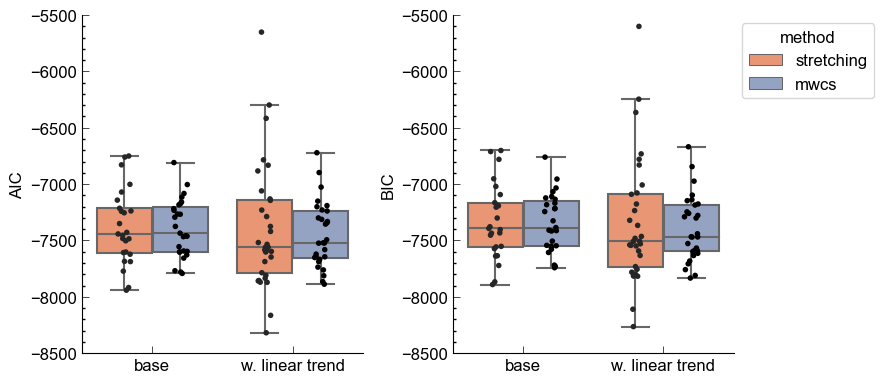

In [11]:
#1. Plot absolute AIC and BIC

np.random.seed(20230420)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

key="AIC"
sns.boxplot(x="modelcase", y=key, hue="method",data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[0])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[0])
axs[0].set_ylabel("AIC")
axs[0].set_ylim([-8500, -5500])

key="BIC"
sns.boxplot(x="modelcase", y=key, hue="method",data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[1])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[1])
axs[1].set_ylabel("BIC")
axs[1].set_ylim([-8500, -5500])

plt.setp(axs, xlabel=None)
axs[0].get_legend().remove()
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1), )
sns.despine()
# axs.set(axs, xlabel=None)

fig.tight_layout()

foname = (output_imgdir+"/MCMC_absoluteAICBIC_{}.png".format(freqband))
plt.savefig(foname, dpi=300, bbox_inches='tight')


### Compute ΔAIC and ΔBIC for each station pair
The comparison of median with the abslute AIC and BIC is essentially not appropriate. We need to compair them by station pairs. They are defined as

$$\Delta AIC = AIC_{w.lin} - AIC_{base},$$
$$\Delta BIC = BIC_{w.lin} - BIC_{base}.$$

If they are negative, i.e. IC with linear trend is smaller, the model with linear trend is considered as better to the data.
There could be a lack in the pair between base and w. linear trend models due to the thresholding of residuals. Thus, we first search if the pair exists, and compute the difference between them.

In [12]:
stationlist = np.sort(np.unique(df_all_residuthresh.index.values))

In [13]:
df_delAICBIC = pd.DataFrame(columns=["method", "ICtype", "value"])

for stindex in stationlist:
# stindex = stationlist[10]
#     print(stindex)
    df_pair = df_all_residuthresh.loc[stindex, :]

    # stretching
    if not isinstance(df_pair["method"]=="stretching", (bool)):
        df_pair_stretching = df_pair[df_pair["method"]=="stretching"]
        if len(df_pair_stretching)==2:
            delAIC_wlin = df_pair_stretching[df_pair_stretching["modelcase"]=="w. linear trend"].AIC.values[0]
            delAIC_base = df_pair_stretching[df_pair_stretching["modelcase"]=="base"].AIC.values[0]
            delBIC_wlin = df_pair_stretching[df_pair_stretching["modelcase"]=="w. linear trend"].BIC.values[0]
            delBIC_base = df_pair_stretching[df_pair_stretching["modelcase"]=="base"].BIC.values[0]
            delAIC_stretching = delAIC_wlin - delAIC_base
            delBIC_stretching = delBIC_wlin - delBIC_base
        else:
            delAIC_stretching = np.nan
            delBIC_stretching = np.nan
    else:
        delAIC_stretching = np.nan
        delBIC_stretching = np.nan

#     print(delAIC_stretching, delBIC_stretching)
    
    # mwcs
    if not isinstance(df_pair["method"]=="mwcs", (bool)):
        df_pair_mwcs = df_pair[df_pair["method"]=="mwcs"]
        if len(df_pair_mwcs)==2:
            delAIC_wlin = df_pair_mwcs[df_pair_mwcs["modelcase"]=="w. linear trend"].AIC.values[0]
            delAIC_base = df_pair_mwcs[df_pair_mwcs["modelcase"]=="base"].AIC.values[0]
            delBIC_wlin = df_pair_mwcs[df_pair_mwcs["modelcase"]=="w. linear trend"].BIC.values[0]
            delBIC_base = df_pair_mwcs[df_pair_mwcs["modelcase"]=="base"].BIC.values[0]
            delAIC_mwcs = delAIC_wlin - delAIC_base
            delBIC_mwcs = delBIC_wlin - delBIC_base
        else:
            delAIC_mwcs = np.nan
            delBIC_mwcs = np.nan
    else:
        delAIC_mwcs = np.nan
        delBIC_mwcs = np.nan
        
#     print(delAIC_mwcs, delBIC_mwcs)

    ICdata = {'index':[stindex, stindex, stindex, stindex], "method":["stretching", "stretching", "mwcs", "mwcs"], "ICtype":["ΔAIC", "ΔBIC", "ΔAIC", "ΔBIC"],
              "value":[delAIC_stretching, delBIC_stretching, delAIC_mwcs, delBIC_mwcs]}

    df_delIC_pair = pd.DataFrame.from_dict(ICdata).set_index("index")
    df_delAICBIC = pd.concat([df_delAICBIC, df_delIC_pair], ignore_index=True)


In [14]:
df_delAICBIC

,method,ICtype,value
0,stretching,ΔAIC,-246.720550
1,stretching,ΔBIC,-242.604658
2,mwcs,ΔAIC,-36.094300
3,mwcs,ΔBIC,-31.978408
4,stretching,ΔAIC,-129.552128
...,...,...,...
135,mwcs,ΔBIC,-85.227254
136,stretching,ΔAIC,-416.560389
137,stretching,ΔBIC,-412.401294
138,mwcs,ΔAIC,-133.432095


In [15]:
# cpalette_IC

In [ ]:
#1. Plot absolute AIC and BIC
cpalette_IC=np.array(sns.color_palette("Set1"))[1:5]
cpalette_IC = np.array([[141,160,203], [178,223,138]])/255
np.random.seed(20230420)
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))

# ax.grid(True)
# ax.set_axisbelow(True)

sns.boxplot(x="method", y="value", hue="ICtype", data=df_delAICBIC, showfliers=False, palette=cpalette_IC, ax=ax, saturation=0.75)
sns.stripplot(x="method", y="value", hue="ICtype", data=df_delAICBIC, jitter=True, dodge=True, palette='dark:k', size=js, legend=None, ax=ax)
ax.set_ylabel("ΔAIC, ΔBIC")
ax.set_ylim([-450, 50])

fontsize = 13 
ax.text(-0.33, 17, "ΔAIC", fontsize=fontsize)
ax.text(0.07, 17, "ΔBIC", fontsize=fontsize)

ax.text(0.67, 17, "ΔAIC", fontsize=fontsize)
ax.text(1.06, 17, "ΔBIC", fontsize=fontsize)

plt.setp(ax, xlabel=None)

ax.get_legend().remove()
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title="")
sns.despine()
# axs.set(axs, xlabel=None)
# plt.grid(axis='x')

fig.tight_layout()

foname = (output_imgdir+"/MCMC_DeltaAICBIC_{}.png".format(freqband))
plt.savefig(foname, dpi=300, bbox_inches='tight')


In [17]:
df_all_residuthresh

,method,modelcase,freqband,a0,p1,a_{precip},p2,t_{shiftdays},S1,log10tmin1,...,logf,AIC,BIC,residu_absmean,residu_var,tmin1,tmin2,tmax1,tmax2,blin_1overyear
BP.CCRB-BP.CCRB,stretching,base,0.9-1.2,0.004573,-0.000080,0.02426,0.001560,1.898185,0.019666,6.293,...,-3.676690,-7350.560812,-7301.170107,0.023012,0.000851,0.062258,0.314191,13.475987,11.777417,NaN
BP.CCRB-BP.EADB,stretching,base,0.9-1.2,0.011227,-0.000323,0.02426,0.000636,6.593236,0.027554,6.293,...,-3.868492,-7002.237733,-6953.196436,0.025107,0.001150,0.062258,0.314191,11.147163,11.382732,NaN
BP.CCRB-BP.LCCB,stretching,base,0.9-1.2,0.014756,-0.000105,0.02426,0.000460,57.668390,0.009621,6.293,...,-3.835801,-7142.353144,-7093.311847,0.023146,0.000844,0.062258,0.314191,14.484268,15.947748,NaN
BP.CCRB-BP.MMNB,stretching,base,0.9-1.2,0.005713,-0.000103,0.02426,0.000605,89.523260,0.024734,6.293,...,-3.709526,-6760.332193,-6711.763727,0.025168,0.001076,0.062258,0.314191,11.237575,9.550891,NaN
BP.CCRB-BP.SCYB,stretching,base,0.9-1.2,0.006322,-0.000044,0.02426,0.001349,43.098595,0.020037,6.293,...,-4.157974,-7241.746270,-7192.732277,0.018755,0.000640,0.062258,0.314191,11.557173,10.005364,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BP.SCYB-BP.SMNB,mwcs,w. linear trend,0.9-1.2,-0.019905,-0.003957,0.03888,0.000844,0.812753,0.002156,4.903,...,-3.762613,-7667.776395,-7614.098743,0.016310,0.000525,0.002536,0.312028,21618.164448,4.526114,0.002444
BP.SCYB-BP.VCAB,mwcs,w. linear trend,0.9-1.2,-0.012694,-0.004092,0.03888,0.000260,14.851086,0.009273,4.903,...,-3.607565,-7581.616855,-7527.826403,0.017025,0.000731,0.002536,0.312028,30.015221,8.524757,0.001552
BP.SMNB-BP.SMNB,mwcs,w. linear trend,0.9-1.2,-0.004944,-0.000089,0.03888,0.000895,0.635257,0.006140,4.903,...,-3.222858,-7300.463339,-7246.533251,0.029984,0.001589,0.002536,0.312028,29.150075,1.122201,0.001353
BP.SMNB-BP.VCAB,mwcs,w. linear trend,0.9-1.2,-0.037177,-0.007962,0.03888,-0.001224,88.912238,0.004194,4.903,...,-3.366526,-7355.132381,-7301.341929,0.023675,0.001192,0.002536,0.312028,990.259392,1.176422,0.004133


In [18]:
N_stretching = len(df_all_residuthresh[(df_all_residuthresh["method"]=="stretching") & (df_all_residuthresh["modelcase"]=="w. linear trend")])
N_mwcs = len(df_all_residuthresh[(df_all_residuthresh["method"]=="mwcs") & (df_all_residuthresh["modelcase"]=="w. linear trend")])

print(N_stretching, N_mwcs)

32 29


# Plot linear slope

In [ ]:
df_all_residuthresh_blin = df_all_residuthresh[df_all_residuthresh["modelcase"]=="w. linear trend"]

np.random.seed(20230419)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))

key = "blin_1overyear" #"b_{lin}"

sns.boxplot(x="method", y=key, data=df_all_residuthresh_blin, showfliers=False, palette=cpalette, ax=ax, width=0.4)
sns.stripplot(x="method", y=key, data=df_all_residuthresh_blin, jitter=True, dodge=True, color='k', size=js, legend=None, ax=ax)
ax.set_ylabel("Slope b [%/year]")
# ax.set_ylim([-0.002, 0.01])

plt.setp(ax, xlabel=None)
# ax.legend()
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), )
sns.despine()

fig.tight_layout()

foname = (output_imgdir+"/MCMC_modelparam_boxplot_blin_{}.png".format(freqband))
plt.savefig(foname, dpi=300, bbox_inches='tight')

In [20]:
median_b_stretching = df_all_residuthresh_blin[df_all_residuthresh_blin["method"]=="stretching"][key].median()
median_b_mwcs = df_all_residuthresh_blin[df_all_residuthresh_blin["method"]=="mwcs"][key].median()
print(f"medians of the slope b are {median_b_stretching:.6f} for stretching and {median_b_mwcs:.6f} for mwcs, respectively.")

medians of the slope b are 0.004821 for stretching and 0.002694 for mwcs, respectively.


In [21]:
df_all_residuthresh_blin[df_all_residuthresh_blin["blin_1overyear"]<0]

,method,modelcase,freqband,a0,p1,a_{precip},p2,t_{shiftdays},S1,log10tmin1,...,logf,AIC,BIC,residu_absmean,residu_var,tmin1,tmin2,tmax1,tmax2,blin_1overyear
BP.LCCB-BP.VCAB,stretching,w. linear trend,0.9-1.2,0.040455,-0.002997,0.02426,0.000793,2.676726,0.011111,6.293,...,-4.025761,-7687.588558,-7633.302284,0.022382,0.001083,0.062258,0.314191,1.861312,47.266531,-0.000973


In [22]:
df_all_residuthresh_blin

,method,modelcase,freqband,a0,p1,a_{precip},p2,t_{shiftdays},S1,log10tmin1,...,logf,AIC,BIC,residu_absmean,residu_var,tmin1,tmin2,tmax1,tmax2,blin_1overyear
BP.CCRB-BP.CCRB,stretching,w. linear trend,0.9-1.2,-0.050196,-0.001438,0.02426,0.001343,1.970812,0.011752,6.293,...,-4.044325,-7597.281362,-7543.774765,0.017204,0.000491,0.062258,0.314191,2.787458,26.549043,0.004446
BP.CCRB-BP.EADB,stretching,w. linear trend,0.9-1.2,-0.042284,-0.004332,0.02426,-0.000183,38.992332,0.015520,6.293,...,-4.199614,-7131.789862,-7078.661790,0.020481,0.000856,0.062258,0.314191,9.024682,13.155885,0.004016
BP.CCRB-BP.LCCB,stretching,w. linear trend,0.9-1.2,-0.020279,-0.003624,0.02426,-0.000450,5.782466,0.008481,6.293,...,-4.255874,-7288.278229,-7235.150158,0.018931,0.000602,0.062258,0.314191,1.167140,253.075703,0.004815
BP.CCRB-BP.MMNB,stretching,w. linear trend,0.9-1.2,-0.034732,-0.003584,0.02426,-0.000724,0.549409,0.015478,6.293,...,-3.862281,-6883.447112,-6830.831274,0.020956,0.000801,0.062258,0.314191,14.094806,13.343342,0.003454
BP.CCRB-BP.SCYB,stretching,w. linear trend,0.9-1.2,-0.049128,-0.001308,0.02426,0.001106,44.032674,0.005336,6.293,...,-4.598888,-7534.431223,-7481.332731,0.013858,0.000331,0.062258,0.314191,8.601509,8.096428,0.003730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BP.SCYB-BP.SMNB,mwcs,w. linear trend,0.9-1.2,-0.019905,-0.003957,0.03888,0.000844,0.812753,0.002156,4.903,...,-3.762613,-7667.776395,-7614.098743,0.016310,0.000525,0.002536,0.312028,21618.164448,4.526114,0.002444
BP.SCYB-BP.VCAB,mwcs,w. linear trend,0.9-1.2,-0.012694,-0.004092,0.03888,0.000260,14.851086,0.009273,4.903,...,-3.607565,-7581.616855,-7527.826403,0.017025,0.000731,0.002536,0.312028,30.015221,8.524757,0.001552
BP.SMNB-BP.SMNB,mwcs,w. linear trend,0.9-1.2,-0.004944,-0.000089,0.03888,0.000895,0.635257,0.006140,4.903,...,-3.222858,-7300.463339,-7246.533251,0.029984,0.001589,0.002536,0.312028,29.150075,1.122201,0.001353
BP.SMNB-BP.VCAB,mwcs,w. linear trend,0.9-1.2,-0.037177,-0.007962,0.03888,-0.001224,88.912238,0.004194,4.903,...,-3.366526,-7355.132381,-7301.341929,0.023675,0.001192,0.002536,0.312028,990.259392,1.176422,0.004133


# Plot other model parameters

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(14, 6))

np.random.seed(20230420)

# a0
key="a0"
sns.boxplot(x="modelcase", y=key, hue="method",data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[0, 0])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[0, 0])
axs[0, 0].set_ylabel("a0")
axs[0, 0].set_ylim([-0.1, 0.05])

# p1
key="p1"
sns.boxplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[0, 1])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[0, 1])
axs[0, 1].set_ylabel("p1")
axs[0, 1].set_ylim([-0.01, 0.001])
# axs[0, 1].set_yscale('log')


# p2
key="p2"
sns.boxplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[0, 2])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[0, 2])
axs[0, 2].set_ylabel("p2")
axs[0, 2].set_ylim([-0.0022, 0.0022])

# t_shift
key="t_{shiftdays}"
sns.boxplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[0, 3])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[0, 3])
axs[0, 3].set_ylabel("Temperature shift [days]")
axs[0, 3].set_ylim([-5, 95])
axs[0, 3].set_yticks(np.arange(0, 95, 15))

Slimit = [-0.002, 0.1]
tmaxlimit=[1e0, 1e4]

# S1
key="S1"
sns.boxplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[1, 0])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[1, 0])
axs[1, 0].set_ylabel("S1")
axs[1, 0].set_ylim(Slimit)


# tmax1
key="tmax1"
sns.boxplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[1, 1])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[1, 1])
axs[1, 1].set_ylabel("SS Healing max time [year]")
axs[1, 1].set_yscale('log')
axs[1, 1].set_ylim(tmaxlimit)

# S2
key="S2"
sns.boxplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[1, 2])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[1, 2])
axs[1, 2].set_ylabel("S2")
axs[1, 2].set_ylim(Slimit)


# tmax2
key="tmax2"
sns.boxplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, showfliers=False, palette=cpalette, ax=axs[1, 3])
sns.stripplot(x="modelcase", y=key, hue="method", data=df_all_residuthresh, jitter=True, dodge=True, palette='dark:k', legend=None, size=js, ax=axs[1, 3])
axs[1, 3].set_ylabel("PF Healing max time [year]")
axs[1, 3].set_yscale('log')
axs[1, 3].set_ylim(tmaxlimit)

plt.setp(axs, xlabel=None)

for i in range(2):
    for j in range(4):
#         axs[i, j].grid(True, which='major', axis='y')
#         axs[i, j].set_axisbelow(True)
#         axs[i, j].legend(handles[:0], labels[:0])
        if i==0 and j==3:
            continue
        else:
            axs[i,j].get_legend().remove()
    
sns.move_legend(axs[0,3], "upper left", bbox_to_anchor=(1, 1), )
sns.despine()
# axs.set(axs, xlabel=None)

fig.tight_layout()

foname = (output_imgdir+"/MCMC_modelparam_boxplot_{}.png".format(freqband))
plt.savefig(foname, dpi=300, bbox_inches='tight')

# Plot paramters as a function of fault normal distance

Run the `Maps/BPnetwork_Faultdist/code/BPnetwork_computeFaultdist.ipynb` to compute the fault normal distance and copy the data into the `../data_stats/`.

In [24]:
df_stationdist = pd.read_csv("../data_stats/BPnetwork_faultnormaldist.csv", index_col=0)

In [25]:
df_stationdist

,latitude,longitude,depth,faultnormal_dist,locside
station,,,,,
CCRB,35.95718,-120.55158,251,3.027717,pacific
EADB,35.89522,-120.42262,245,0.852322,northamerican
FROB,35.91095,-120.48688,284,2.222301,pacific
GHIB,35.83225,-120.34728,63,1.103975,northamerican
JCNB,35.93897,-120.43112,224,3.583676,northamerican
JCSB,35.92117,-120.43400,155,2.052458,northamerican
LCCB,35.98006,-120.51423,252,1.170606,northamerican
MMNB,35.95650,-120.49600,221,0.603893,northamerican
RMNB,36.00087,-120.47772,73,5.155094,northamerican


In [26]:
# # append pairtype: Pacific, North America, Crossing
# for index, row in df_all_residuthresh.iterrows():
#     print(index, )
    

In [27]:
# index = "BP.LCCB-BP.MMNB"
for index, row in df_all_residuthresh.iterrows():

    netsta1, netsta2 = index.split("-")
    sta1, sta2 = [x.split(".")[1] for x in index.split("-")]
    # find corrtype
    if sta1 == sta2:
        corrtype = "AC" # auto-correlation
    else:
        corrtype = "CC" # cross-correlation

    # find loctype
    staside1 = df_stationdist.loc[sta1].locside
    staside2 = df_stationdist.loc[sta2].locside

    if staside1==staside2:
        if staside1=="northamerican":
            loctype = "North America"
        elif staside1=="pacific":
            loctype = "Pacific"
            
    else:
        loctype = "Crossing"

    loc_corrtype = f"{loctype}-{corrtype}"

    # Fault normal distance
    stadist1 = df_stationdist.loc[sta1].faultnormal_dist
    stadist2 = df_stationdist.loc[sta2].faultnormal_dist
    pairdist = np.mean([stadist1, stadist2]) # fault normal distance is evaluated as an average of two stations; in the case of AC stadist1 and stadist1 are identical.
    df_all_residuthresh.loc[index, "pairdist"] = pairdist
    df_all_residuthresh.loc[index, "loc_corrtype"] = loc_corrtype



In [28]:
df_all_residuthresh

,method,modelcase,freqband,a0,p1,a_{precip},p2,t_{shiftdays},S1,log10tmin1,...,BIC,residu_absmean,residu_var,tmin1,tmin2,tmax1,tmax2,blin_1overyear,pairdist,loc_corrtype
BP.CCRB-BP.CCRB,stretching,base,0.9-1.2,0.004573,-0.000080,0.02426,0.001560,1.898185,0.019666,6.293,...,-7301.170107,0.023012,0.000851,0.062258,0.314191,13.475987,11.777417,NaN,3.027717,Pacific-AC
BP.CCRB-BP.EADB,stretching,base,0.9-1.2,0.011227,-0.000323,0.02426,0.000636,6.593236,0.027554,6.293,...,-6953.196436,0.025107,0.001150,0.062258,0.314191,11.147163,11.382732,NaN,1.940019,Crossing-CC
BP.CCRB-BP.LCCB,stretching,base,0.9-1.2,0.014756,-0.000105,0.02426,0.000460,57.668390,0.009621,6.293,...,-7093.311847,0.023146,0.000844,0.062258,0.314191,14.484268,15.947748,NaN,2.099161,Crossing-CC
BP.CCRB-BP.MMNB,stretching,base,0.9-1.2,0.005713,-0.000103,0.02426,0.000605,89.523260,0.024734,6.293,...,-6711.763727,0.025168,0.001076,0.062258,0.314191,11.237575,9.550891,NaN,1.815805,Crossing-CC
BP.CCRB-BP.SCYB,stretching,base,0.9-1.2,0.006322,-0.000044,0.02426,0.001349,43.098595,0.020037,6.293,...,-7192.732277,0.018755,0.000640,0.062258,0.314191,11.557173,10.005364,NaN,2.462454,Crossing-CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BP.SCYB-BP.SMNB,mwcs,w. linear trend,0.9-1.2,-0.019905,-0.003957,0.03888,0.000844,0.812753,0.002156,4.903,...,-7614.098743,0.016310,0.000525,0.002536,0.312028,21618.164448,4.526114,0.002444,2.805249,Crossing-CC
BP.SCYB-BP.VCAB,mwcs,w. linear trend,0.9-1.2,-0.012694,-0.004092,0.03888,0.000260,14.851086,0.009273,4.903,...,-7527.826403,0.017025,0.000731,0.002536,0.312028,30.015221,8.524757,0.001552,3.216497,Crossing-CC
BP.SMNB-BP.SMNB,mwcs,w. linear trend,0.9-1.2,-0.004944,-0.000089,0.03888,0.000895,0.635257,0.006140,4.903,...,-7246.533251,0.029984,0.001589,0.002536,0.312028,29.150075,1.122201,0.001353,3.713306,Pacific-AC
BP.SMNB-BP.VCAB,mwcs,w. linear trend,0.9-1.2,-0.037177,-0.007962,0.03888,-0.001224,88.912238,0.004194,4.903,...,-7301.341929,0.023675,0.001192,0.002536,0.312028,990.259392,1.176422,0.004133,4.124554,Pacific-CC


In [29]:
# Extract the model case of with trend and divide into stretching and mwcs
df_all_residuthresh_base = df_all_residuthresh[df_all_residuthresh["modelcase"]=="base"]
df_all_residuthresh_wlin = df_all_residuthresh[df_all_residuthresh["modelcase"]=="w. linear trend"]

df_all_residuthresh_wlin_stretching = df_all_residuthresh_wlin[df_all_residuthresh_wlin["method"]=="stretching"]
df_all_residuthresh_wlin_mwcs = df_all_residuthresh_wlin[df_all_residuthresh_wlin["method"]=="mwcs"]

In [30]:
df_annot_all = pd.DataFrame(columns=["method", "index", "x", "y", "xtext", "ytext"])

# Assemble for the annotations of outliers
annotation_index_stretching = ['BP.GHIB-BP.GHIB', 'BP.LCCB-BP.VCAB']
annotation_index_mwcs = ['BP.EADB-BP.GHIB', 'BP.EADB-BP.MMNB', 'BP.LCCB-BP.LCCB']

dxytext_stretching = [(0.5, -0.001), (0.5, 0.001)]
dxytext_mwcs= [(0.4, 0.0), (0.5, 6e-4), (0.5, -8e-4)]

for i, annotindex in enumerate(annotation_index_stretching):
#     annotindex = annotation_index_stretching[0]
    sta1, sta2 = [x.split(".")[1] for x in annotindex.split("-")]
    df_annot = df_all_residuthresh_wlin_stretching[df_all_residuthresh_wlin_stretching.index == annotindex]
    annot_blin = df_annot.blin_1overyear.values[0]
    annot_dist = df_annot.pairdist.values[0]
    d_annot = {"method":["stretching"], "index":f"{sta1}-{sta2}", "x":[annot_dist], "y":[annot_blin], 
               "xtext":[annot_dist+dxytext_stretching[i][0]], "ytext":[annot_blin++dxytext_stretching[i][1]]}
    df_annot_all = pd.concat([df_annot_all, pd.DataFrame.from_dict(d_annot)], ignore_index=True)

for i, annotindex in enumerate(annotation_index_mwcs):
#     annotindex = annotation_index_stretching[0]
    sta1, sta2 = [x.split(".")[1] for x in annotindex.split("-")]
    df_annot = df_all_residuthresh_wlin_mwcs[df_all_residuthresh_wlin_mwcs.index == annotindex]
    annot_blin = df_annot.blin_1overyear.values[0]
    annot_dist = df_annot.pairdist.values[0]
    d_annot = {"method":["mwcs"], "index":f"{sta1}-{sta2}", "x":[annot_dist], "y":[annot_blin], 
               "xtext":[annot_dist+dxytext_mwcs[i][0]], "ytext":[annot_blin++dxytext_mwcs[i][1]]}
    df_annot_all = pd.concat([df_annot_all, pd.DataFrame.from_dict(d_annot)], ignore_index=True)

df_annot_all

,method,index,x,y,xtext,ytext
0,stretching,GHIB-GHIB,1.103975,0.013355,1.603975,0.012355
1,stretching,LCCB-VCAB,2.853204,-0.000973,3.353204,0.000027
2,mwcs,EADB-GHIB,0.978149,0.007122,1.378149,0.007122
3,mwcs,EADB-MMNB,0.728108,0.005346,1.228108,0.005946
4,mwcs,LCCB-LCCB,1.170606,0.005255,1.670606,0.004455


## Plot b_{lin} with fault normal distance 

In [ ]:
np.random.seed(20230419)
cpalette_scatter="colorblind"

plt.rcParams["xtick.minor.visible"] = True
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# axs[0].grid(True, which="both")
# axs[1].grid(True, which="both")

key = "blin_1overyear" #"b_{lin}"
ms = 50

hue_order=["Pacific-AC", "Pacific-CC", "North America-AC", "North America-CC", "Crossing-CC"]

sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_stretching, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
                palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[0])
sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_mwcs, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
                palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[1])

axs[0].set_title("stretching")
axs[1].set_title("mwcs")

axs[0].set_ylim([-0.002, 0.014])
axs[1].set_ylim([-0.002, 0.014])

# plt.setp(ax, xlabel=None)
# ax.legend()
axs[0].get_legend().remove()
sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1), title="")
# sns.despine()

for i in range(2):
    axs[i].set_xlim([0, 5])
    axs[i].set_xlabel("Averaged fault normal distance [km]")
    axs[i].set_ylabel("Slope b [%/year]")
#     axs[i].set_yscale("log")

arrow_dict = dict(color="black", shrink=0.2, width=0, headwidth=0 )
                  
#---Annotate index for some outliers---#
for index, row in df_annot_all.iterrows():
    if row["method"] == "stretching":
        figid = 0
    else:
        figid = 1

    axs[figid].annotate(row["index"],
                xy = (row.x, row.y), xytext = (row.xtext, row.ytext),
                arrowprops = arrow_dict, size = 11, horizontalalignment='left',)

fig.tight_layout()

foname = (output_imgdir+"/MCMC_modelparam_blin_withFaultnormaldist_{}.png".format(freqband))
plt.savefig(foname, dpi=300, bbox_inches='tight')

# Plot the other model parameters with fault normal distance

We plot the results associated with base & w.lin, and stretching and mwcs separately. 

## plot base model

In [32]:
dvvmodel = "stretching"
df_all_residuthresh_base[df_all_residuthresh_base["method"]==dvvmodel].columns

Index(['method', 'modelcase', 'freqband', 'a0', 'p1', 'a_{precip}', 'p2',
       't_{shiftdays}', 'S1', 'log10tmin1', 'log10tmax1', 'S2', 'log10tmin2',
       'log10tmax2', 'b_{lin}', 'logf', 'AIC', 'BIC', 'residu_absmean',
       'residu_var', 'tmin1', 'tmin2', 'tmax1', 'tmax2', 'blin_1overyear',
       'pairdist', 'loc_corrtype'],
      dtype='object')

In [ ]:
np.random.seed(20230427)
fig, axs = plt.subplots(6, 4, figsize=(14, 16), sharex=False, gridspec_kw=dict(height_ratios=[1, 1, 1, 0.02, 1, 1]))

for i in range(4):
    axs[0, i].set_axis_off()
    axs[3, i].set_axis_off()

ms = 50
hue_order=["Pacific-AC", "Pacific-CC", "North America-AC", "North America-CC", "Crossing-CC"]

for ii, dvvmodel in enumerate(["stretching", "mwcs"]):
    if ii == 0:
        i1, i2 = (1, 2)
    else:
        i1, i2 = (4, 5)
    
    df_all_residuthresh_base_case = df_all_residuthresh_base[df_all_residuthresh_base["method"]==dvvmodel]
    
    # a0
    key="a0"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_base_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
            palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i1, 0])
    axs[i1, 0].set_ylabel("a0")
    axs[i1, 0].set_ylim([-0.1, 0.05])

    # p1
    key="p1"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_base_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i1, 1])
    axs[i1, 1].set_ylabel("p1")
    axs[i1, 1].set_ylim([-0.01, 0.001])
    
    # p2
    key="p2"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_base_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i1, 2])
    axs[i1, 2].set_ylabel("p2")
    axs[i1, 2].set_ylim([-0.0022, 0.0022])
    
    # t_shift
    key="t_{shiftdays}"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_base_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i1, 3])
    axs[i1, 3].set_ylabel("Temperature shift [days]")
    axs[i1, 3].set_ylim([-5, 95])
    axs[i1, 3].set_yticks(np.arange(0, 95, 15))
    
    Slimit = [-0.002, 0.1]
    tmaxlimit=[1e-1, 1e4]

    # S1
    key="S1"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_base_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i2, 0])
    axs[i2, 0].set_ylabel("S1")
    axs[i2, 0].set_ylim(Slimit)


    # tmax1
    key="tmax1"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_base_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i2, 1])
    axs[i2, 1].set_ylabel("SS Healing max time [year]")
    axs[i2, 1].set_yscale('log')
    axs[i2, 1].set_ylim(tmaxlimit)

    # S2
    key="S2"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_base_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i2, 2])
    axs[i2, 2].set_ylabel("S2")
    axs[i2, 2].set_ylim(Slimit)

    # tmax2
    key="tmax2"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_base_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i2, 3])
    axs[i2, 3].set_ylabel("PF Healing max time [year]")
    axs[i2, 3].set_yscale('log')
    axs[i2, 3].set_ylim(tmaxlimit)
    

plt.setp(axs, xlabel=None)

for i in [1, 2, 4, 5]:
    for j in range(4):
        axs[i, j].set_xlim([0, 5])
        axs[i, j].set_xticks(range(6))
        axs[i, j].set_xlabel("Averaged fault normal distance [km]")
#         axs[i, j].grid(True, which='both', axis='both')
        axs[i, j].set_axisbelow(False)
        if i==1 and j==3:
            continue
        else:
            axs[i,j].get_legend().remove()
    
fig.tight_layout()

sns.move_legend(axs[1, 3], "upper center", bbox_to_anchor=(0.6, 1.7), title="")

plt.text(0, 0.2, 'Base model', horizontalalignment='center', verticalalignment='center', transform = axs[0,0].transAxes, fontsize=16, fontweight="bold")
plt.text(0, 0, '(a) Stretching', horizontalalignment='center', verticalalignment='center', transform = axs[0,0].transAxes, fontsize=16, fontweight="bold")
plt.text(0, -6.0, '(b) mwcs', horizontalalignment='center', verticalalignment='center', transform = axs[3,0].transAxes, fontsize=16, fontweight="bold")

foname = (output_imgdir+"/MCMC_modelparam_all_withFaultnormaldist_base_{}.png".format(freqband))
plt.savefig(foname, dpi=300, bbox_inches='tight')

## Plot w.lin model

In [ ]:
np.random.seed(20230427)
fig, axs = plt.subplots(6, 4, figsize=(14, 16), sharex=False, gridspec_kw=dict(height_ratios=[1, 1, 1, 0.02, 1, 1]))

for i in range(4):
    axs[0, i].set_axis_off()
    axs[3, i].set_axis_off()

ms = 50
hue_order=["Pacific-AC", "Pacific-CC", "North America-AC", "North America-CC", "Crossing-CC"]

for ii, dvvmodel in enumerate(["stretching", "mwcs"]):
    if ii == 0:
        i1, i2 = (1, 2)
    else:
        i1, i2 = (4, 5)
    
    df_all_residuthresh_wlin_case = df_all_residuthresh_wlin[df_all_residuthresh_wlin["method"]==dvvmodel]
    
    # a0
    key="a0"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
            palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i1, 0])
    axs[i1, 0].set_ylabel("a0")
    axs[i1, 0].set_ylim([-0.1, 0.05])

    # p1
    key="p1"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i1, 1])
    axs[i1, 1].set_ylabel("p1")
    axs[i1, 1].set_ylim([-0.01, 0.001])
    
    # p2
    key="p2"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i1, 2])
    axs[i1, 2].set_ylabel("p2")
    axs[i1, 2].set_ylim([-0.0022, 0.0022])
    
    # t_shift
    key="t_{shiftdays}"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i1, 3])
    axs[i1, 3].set_ylabel("Temperature shift [days]")
    axs[i1, 3].set_ylim([-5, 95])
    axs[i1, 3].set_yticks(np.arange(0, 95, 15))
    
    Slimit = [-0.002, 0.1]
    tmaxlimit=[1e-1, 1e4]

    # S1
    key="S1"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i2, 0])
    axs[i2, 0].set_ylabel("S1")
    axs[i2, 0].set_ylim(Slimit)


    # tmax1
    key="tmax1"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i2, 1])
    axs[i2, 1].set_ylabel("SS Healing max time [year]")
    axs[i2, 1].set_yscale('log')
    axs[i2, 1].set_ylim(tmaxlimit)

    # S2
    key="S2"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i2, 2])
    axs[i2, 2].set_ylabel("S2")
    axs[i2, 2].set_ylim(Slimit)

    # tmax2
    key="tmax2"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[i2, 3])
    axs[i2, 3].set_ylabel("PF Healing max time [year]")
    axs[i2, 3].set_yscale('log')
    axs[i2, 3].set_ylim(tmaxlimit)
    

plt.setp(axs, xlabel=None)

for i in [1, 2, 4, 5]:
    for j in range(4):
        axs[i, j].set_xlim([0, 5])
        axs[i, j].set_xticks(range(6))
        axs[i, j].set_xlabel("Averaged fault normal distance [km]")
#         axs[i, j].grid(True, which='both', axis='both')
        axs[i, j].set_axisbelow(False)
        if i==1 and j==3:
            continue
        else:
            axs[i,j].get_legend().remove()
    
fig.tight_layout()

sns.move_legend(axs[1, 3], "upper center", bbox_to_anchor=(0.6, 1.7), title="")

plt.text(0, 0.2, 'w. linear trend', horizontalalignment='center', verticalalignment='center', transform = axs[0,0].transAxes, fontsize=16, fontweight="bold")
plt.text(0, 0, '(a) Stretching', horizontalalignment='center', verticalalignment='center', transform = axs[0,0].transAxes, fontsize=16, fontweight="bold")
plt.text(0, -6.0, '(b) mwcs', horizontalalignment='center', verticalalignment='center', transform = axs[3,0].transAxes, fontsize=16, fontweight="bold")

foname = (output_imgdir+"/MCMC_modelparam_all_withFaultnormaldist_wlin_{}.png".format(freqband))
plt.savefig(foname, dpi=300, bbox_inches='tight')

In [35]:
# save the sorted station list to plot with the sorted order by fault normal distance
for dvvmethod in ["stretching", "mwcs"]:
    stationpairs_dict_wlin = dict(station_all=df_all_residuthresh_wlin.loc[df_all_residuthresh_wlin["method"]==dvvmethod].sort_values(by=['pairdist']).index)
    pairsdist_dict_wlin = dict(pairdist=df_all_residuthresh_wlin.loc[df_all_residuthresh_wlin["method"]==dvvmethod].sort_values(by=['pairdist']).pairdist)

    with open(inputdatadir+f'/plot_dvvmodel_sortedbydist_wlin_{freqband}_{dvvmethod}.pickle', 'wb') as fo:
        pickle.dump(stationpairs_dict_wlin, fo)
        pickle.dump(pairsdist_dict_wlin, fo)

# Plot the coseismic drop with fault normal distance

The coseismic drop of dv/v with log healing model is given as follows (Snieder et al. 2017):

$$ SR(t_0) = S \log \left(\dfrac{\tau_{max}}{\tau_{min}} \right). $$

It is noted that the coefficient S does not directly represent the coseismic decrease in dv/v. We thus plot it as a function of fault normal distance.

In [36]:
df_all_residuthresh_wlin_case.columns

Index(['method', 'modelcase', 'freqband', 'a0', 'p1', 'a_{precip}', 'p2',
       't_{shiftdays}', 'S1', 'log10tmin1', 'log10tmax1', 'S2', 'log10tmin2',
       'log10tmax2', 'b_{lin}', 'logf', 'AIC', 'BIC', 'residu_absmean',
       'residu_var', 'tmin1', 'tmin2', 'tmax1', 'tmax2', 'blin_1overyear',
       'pairdist', 'loc_corrtype'],
      dtype='object')

In [37]:
for ii, dvvmodel in enumerate(["stretching", "mwcs"]):
    if ii == 0:
        i1, i2 = (1, 2)
    else:
        i1, i2 = (4, 5)
    
    df_all_residuthresh_wlin_case = df_all_residuthresh_wlin[df_all_residuthresh_wlin["method"]==dvvmodel]
    

In [38]:
def get_coseismicdvvdrop(S, logtaumin, logtaumax):
    # rescale taumin and taumax
    taumin = 10**logtaumin # [s]
    taumax = 10**logtaumax # [s]
    return -S*np.log(taumax/taumin) # return as negative



In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=False,)

dvvdroplimit=[-0.2, 0]
cpalette_scatter = "colorblind"
ms = 50
hue_order=["Pacific-AC", "Pacific-CC", "North America-AC", "North America-CC", "Crossing-CC"]

for ii, dvvmodel in enumerate(["stretching", "mwcs"]):
    df_all_residuthresh_wlin_case = df_all_residuthresh_wlin[df_all_residuthresh_wlin["method"]==dvvmodel].copy()
    # Parkfield event corresponds to index 2
    df_all_residuthresh_wlin_case.loc[:, "coseismicdvvdrop"] = df_all_residuthresh_wlin_case.apply(lambda x: get_coseismicdvvdrop(x.S2, x.log10tmin2, x.log10tmax2), axis=1)

    key="coseismicdvvdrop"
    sns.scatterplot(x="pairdist", y=key, data=df_all_residuthresh_wlin_case, hue="loc_corrtype", style="loc_corrtype", hue_order=hue_order,
        palette=cpalette_scatter, s=ms, edgecolor="w", linewidth=0.5, ax=axs[ii])
    axs[ii].set_ylabel("coseismic dv/v decrease\nS$^{PF}$log(τmax/τmin)[%]")
    axs[ii].set_ylim(dvvdroplimit)    

plt.setp(axs, xlabel=None)

for i in range(2):
    axs[i].set_xlim([0, 5])
    axs[i].set_xticks(range(6))
    axs[i].set_xlabel("Averaged fault normal distance [km]")
#         axs[i].grid(True, which='both', axis='both')
    axs[i].set_axisbelow(False)

axs[0].get_legend().remove()
            
fig.tight_layout()

sns.move_legend(axs[1], "upper center", bbox_to_anchor=(1.4, 1.04), title="")

# plt.text(0, 0.2, 'w. linear trend', horizontalalignment='center', verticalalignment='center', transform = axs[0,0].transAxes, fontsize=16, fontweight="bold")
# plt.text(0, 0, '(a) Stretching', horizontalalignment='center', verticalalignment='center', transform = axs[0,0].transAxes, fontsize=16, fontweight="bold")
# plt.text(0, -6.0, '(b) mwcs', horizontalalignment='center', verticalalignment='center', transform = axs[3,0].transAxes, fontsize=16, fontweight="bold")

foname = (output_imgdir+"/MCMC_modelparam_coseismicdrop_withFaultnormaldist_wlin_{}.png".format(freqband))
plt.savefig(foname, dpi=300, bbox_inches='tight')

# Conclusion

In this notebook we plotted the stastical analysis of model parameters estimated by the MCMC inversion.